## todo:

* add z displacement to DF
* ONLY keep station 34
* clean up! 

## Preprocessing temperature, lake, GPS data'



* Trimming data to my study perdio bounds, interpolating using pandas.datetime


* Calculating GPS displacement relative to start of my study period


* Correcting relative GPS displacement by subtracting overall pre-drainage velocity from data


* Calculating GPS velocity


* Compiling all aux data into dataframes based on interpolation window, saving to csv








Data from Garcia et al., 2019


Garcia, L., Luttrell, K., Kilb, D., & Walter, F. (2019). Joint geodetic and seismic analysis of surface crevassing near a seasonal glacier-dammed lake at Gornergletscher, Switzerland. Annals of Glaciology, 60(79), 1-13. doi:10.1017/aog.2018.32


https://www.cambridge.org/core/journals/annals-of-glaciology/article/joint-geodetic-and-seismic-analysis-of-surface-crevassing-near-a-seasonal-glacierdammed-lake-at-gornergletscher-switzerland/15E026FE40EB6CA4E3FD5A4B5602E2F2


Tables 6 and 7 from supplement are used.

Download supplementary material:: 

https://static.cambridge.org/content/id/urn:cambridge.org:id:article:S0260305518000320/resource/name/S0260305518000320sup002.pdf






In [1]:

from scipy.io import loadmat

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (22,10)


## functions

In [2]:

    
def extractStationName(gpsdata, column_number=1):
    '''
    
    '''
            

    n=0
    data_list = []
    
    while n < len(gpsdata[column_number][:]):
        
        try:
            data = gpsdata[column_number][n][0]
            data_list.append(data)
            print(data)
            n = n + 1
    
        except:
            break

            
    return data_list



def trimGPS(gps_disp,gps_jday,doy1=165,doy2=205):
    
    gps_jday_trim = []    
    gps_disp_trim = []
        
    for i in range(0,4): ##skip last station, station#44

        gps_jday_0 = gps_jday[i][gps_jday[i]>=doy1]
        gps_jday_00 = gps_jday_0[gps_jday_0<doy2]



        gps_disp_0 = gps_disp[i][gps_jday[i]>=doy1]
        gps_disp_00 = gps_disp_0[gps_jday_0<doy2]
        
        gps_jday_trim.append(gps_jday_00)
        gps_disp_trim.append(gps_disp_00)    
        

    
    
    return gps_jday_trim, gps_disp_trim


    
    

def calcRelativeGPSDisp(gps_disp_trim,gps_jday_trim,startDoy = 165):
    
### From Lutrell/Garcia's matlab code    
### plot(  GPS_disp.jday  ,   GPS_disp.dis  -    [ ones(length(GPS_disp.t),1)  *  GPS_disp.dis_on_day155   ]
    
    
    relDisp_list = []
    
    for i in range(0,4):
        disp    = gps_disp_trim[i]
        GPS_disp_on_day165 = disp[np.argwhere(gps_jday_trim[i]==165)[0][0]]
        relDisp = disp - (np.ones(len(disp)) * GPS_disp_on_day165)
        relDisp_list.append(relDisp)

    
    return relDisp_list


def correctGPS(gps_jday_trim,relDisp_list,m):


    correct_GPS_list = []
    for i in range(0,4):
        

        day_vector = gps_jday_trim[i] - np.min(gps_jday_trim[i]) 

        slope = day_vector * m[i]

        correct_GPS = relDisp_list[i] - slope
        
        correct_GPS_list.append(correct_GPS)
        
        
    return correct_GPS_list

In [3]:
ls ../..

LICENSE              models/              setup.py
Makefile             notebooks/           src/
README.md            references/          test_environment.py
data/                reports/             tox.ini
docs/                requirements.txt


### Load data

In [4]:


pathIn = '../../data/raw/Bundled_data_2007.mat'
pathOut = '../../data/processed/Garcia/'


mat = loadmat(pathIn)


keys_list = mat.keys()

for keys in mat.keys():
    print(keys)
    exec(f"var_{keys} = mat.get('{keys}')")



name_list = [[row.flat[0] for row in line] for line in mat['GPS_disp'][0][0]]

year = mat['GPS_disp'][0][0][0]
station = extractStationName(name_list, column_number=1)
t = mat['GPS_disp'][0][0][2]
jday = mat['GPS_disp'][0][0][3]
x = mat['GPS_disp'][0][0][4]
y = mat['GPS_disp'][0][0][5]
z = mat['GPS_disp'][0][0][6]
dis = mat['GPS_disp'][0][0][7]
dis_on_day_155 = mat['GPS_disp'][0][0][8]

__header__
__version__
__globals__
GPS_disp
LakeLevel
Meteor
Outlines
Strain_East
Strain_Mid
Strain_West
Station #24
Station #34
Station #36
Station #37
Station #44


# Basic data exploration

What is sampling rate, what are data bounds...

In [5]:
gps_disp = []
gps_jday = []
z_disp = []

doy1=165
doy2=204

for i in range(0,4):
    
    
    
    gps_jday.append(jday[:,i])

    gps_disp.append(dis[:,i])
    
    z_disp.append(z[:,i])

In [6]:
for i in range(0,4):
    

    avg_dt = np.nanmean(np.diff(gps_jday[i]))
    avg_dt_sec = avg_dt * 60*60*24
    doy_0 = np.nanmin(jday[:,i])
    
    
    print(station[i])    
    print(f'Earliest datapoint: DOY {doy_0:.10f}')
    print(f'Sampling rate for GPS: {avg_dt:.10f} days ({avg_dt_sec:.10f} sec) \n')
    

Station #24
Earliest datapoint: DOY 115.5527777778
Sampling rate for GPS: 0.0019961928 days (172.4710543694 sec) 

Station #34
Earliest datapoint: DOY 115.5527777778
Sampling rate for GPS: 0.0015344566 days (132.5770519925 sec) 

Station #36
Earliest datapoint: DOY 115.5527777778
Sampling rate for GPS: 0.0015007062 days (129.6610169492 sec) 

Station #37
Earliest datapoint: DOY 115.5527777778
Sampling rate for GPS: 0.0014861012 days (128.3991474944 sec) 



# GPS

## plot raw GPS

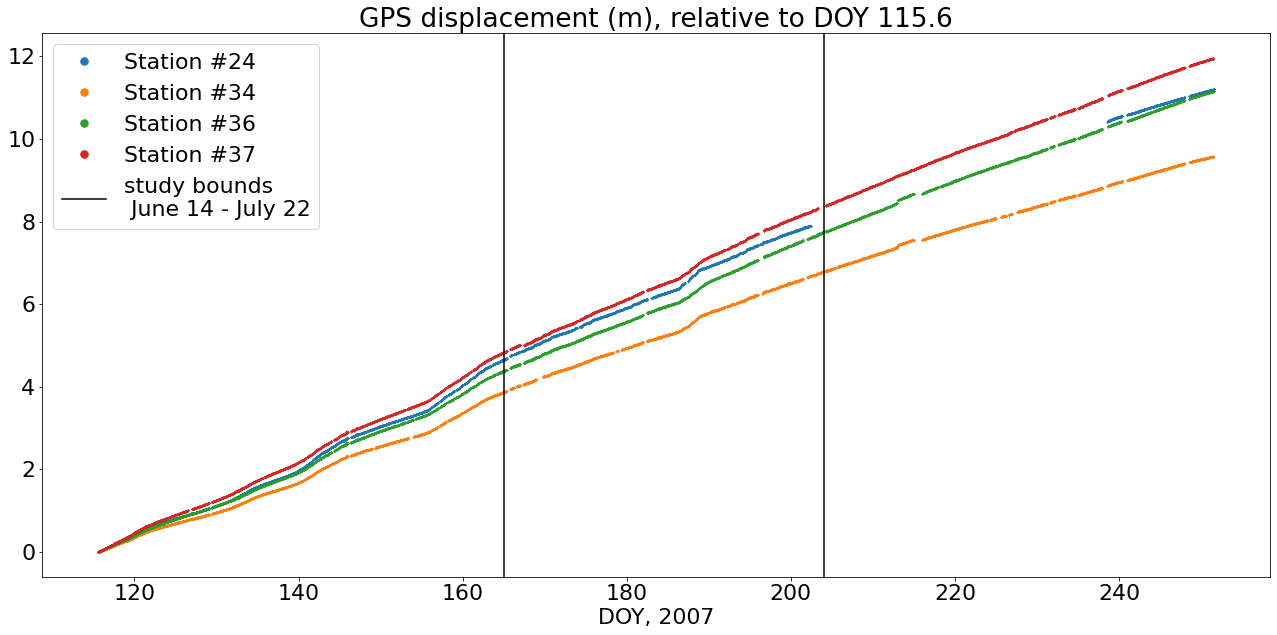

In [7]:



for i in range(0,4):

    plt.plot(gps_jday[i],gps_disp[i],label=station[i],ls='None',marker='.',ms=.5)
    
    ax = plt.gca()

ax.set_title(f'GPS displacement (m), relative to DOY {doy_0:.1f}')
ax.set_xlabel('DOY, 2007')

### my study period
ax.axvline(x=doy1,color='k',label='study bounds \n June 14 - July 22')
ax.axvline(x=doy2,color='k')

ax.legend(markerscale=30);


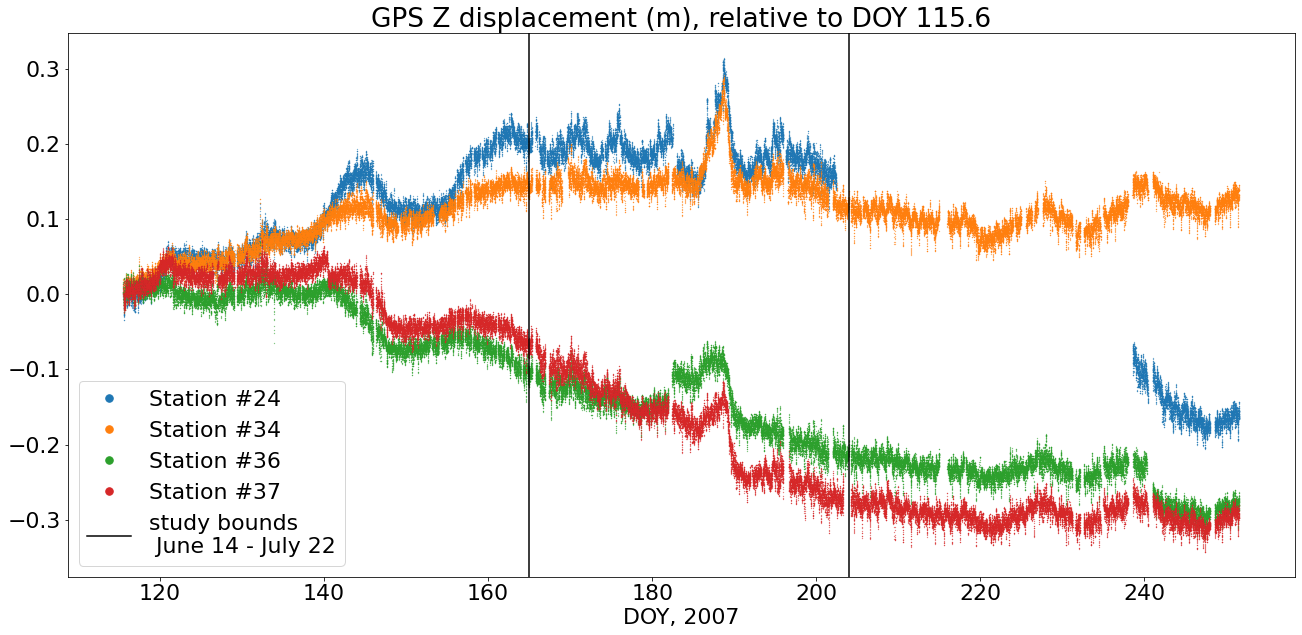

In [8]:
for i in range(0,4):

    plt.plot(gps_jday[i],z_disp[i],label=station[i],ls='None',marker='.',ms=.5)
    
    ax = plt.gca()

ax.set_title(f'GPS Z displacement (m), relative to DOY {doy_0:.1f}')
ax.set_xlabel('DOY, 2007')

### my study period
ax.axvline(x=doy1,color='k',label='study bounds \n June 14 - July 22')
ax.axvline(x=doy2,color='k')

ax.legend(markerscale=30);


## Trim GPS

In [9]:



gps_jday_trim, gps_disp_trim = trimGPS(gps_disp,gps_jday,doy1=doy1,doy2=doy2)
__, z_disp_trim = trimGPS(z_disp,gps_jday,doy1=doy1,doy2=doy2)


# for i in range(0,4):
#     plt.plot(gps_jday_trim[i],gps_disp_trim[i])
    
# plt.xlabel('DOY, 2007')
# plt.title(f'GPS displacement, relative to DOY {doy_0:.1f} (m)  ',fontsize=14)


# ax = plt.gca()
# ### my study period
# ax.axvline(x=doy1,color='k')
# ax.axvline(x=doy2,color='k')


# ax.axvline(x=178,label='midseason',ls='--')
# ax.axvline(x=186,label='(supra)drainage',ls='-')
# ax.axvline(x=195,label='post-drainage',ls='-.')



### calc displacement relative to starttime 

In [10]:
relDisp_list = calcRelativeGPSDisp(gps_disp_trim,gps_jday_trim,startDoy = doy1)
relZ_Disp_list = calcRelativeGPSDisp(z_disp_trim,gps_jday_trim,startDoy = doy1)



Text(0.5, 0, 'DOY, 2007')

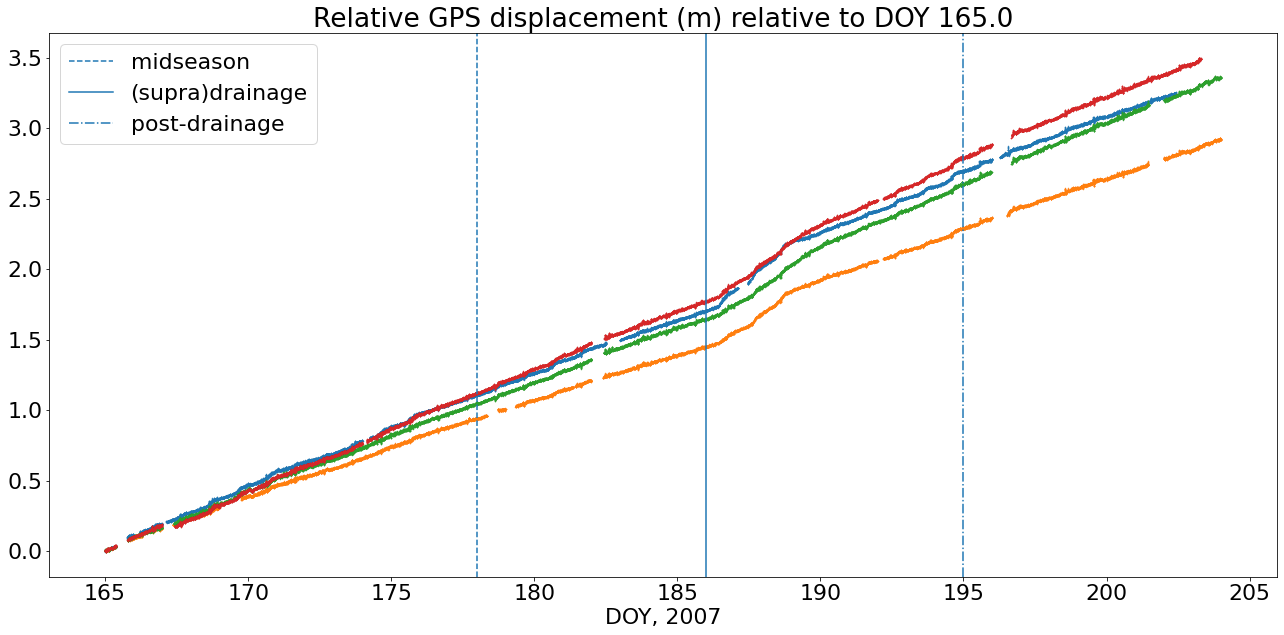

In [11]:

for i in range(0,4):

    plt.plot(gps_jday_trim[i],relDisp_list[i],ls='None',marker='.',ms=1)
    

    
ax = plt.gca()

##timings from table S6

ax.axvline(x=178,label='midseason',ls='--')
ax.axvline(x=186,label='(supra)drainage',ls='-')
ax.axvline(x=195,label='post-drainage',ls='-.')

plt.legend()

plt.title(f'Relative GPS displacement (m) relative to DOY {doy1:.1f}')
plt.xlabel('DOY, 2007')

Text(0.5, 0, 'DOY, 2007')

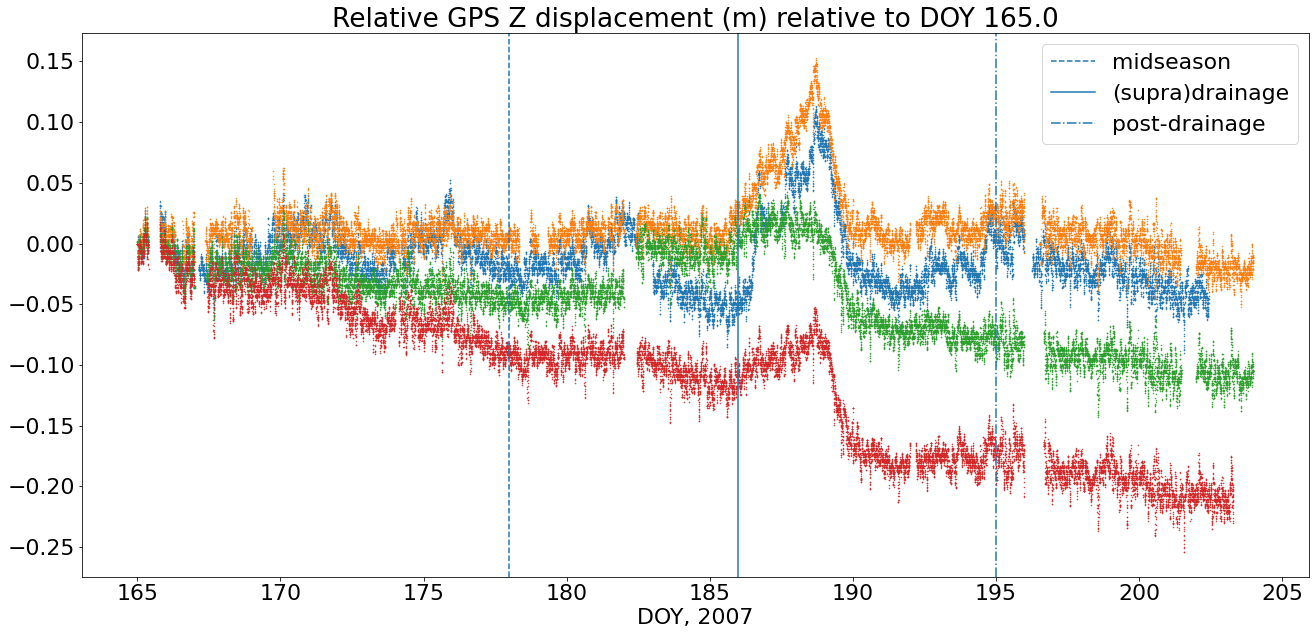

In [12]:

for i in range(0,4):

    plt.plot(gps_jday_trim[i],relZ_Disp_list[i],ls='None',marker='.',ms=1)
    

    
ax = plt.gca()

##timings from table S6

ax.axvline(x=178,label='midseason',ls='--')
ax.axvline(x=186,label='(supra)drainage',ls='-')
ax.axvline(x=195,label='post-drainage',ls='-.')

plt.legend()

plt.title(f'Relative GPS Z displacement (m) relative to DOY {doy1:.1f}')
plt.xlabel('DOY, 2007')

## Convert DOY to pandas datetime objects



In [13]:

gps_datetime = []
gps_datetime_index = []

for i in range(0,4):
    
    gps_datetime_i = pd.to_datetime('2006-12-31') + pd.to_timedelta(gps_jday_trim[i], unit='D')
    gps_datetime_ind = pd.to_datetime('2006-12-31') + pd.to_timedelta(gps_jday_trim[i], unit='D')
    
    gps_datetime.append(gps_datetime_i)
    gps_datetime_index.append(gps_datetime_ind)



## Make list of gps Dataframes

In [15]:
pathOut

'../../data/processed/Garcia/'

In [16]:

gps_df_list = []

for i in range(0,4):
    
    gps_dfi = pd.DataFrame({'datetime_index':gps_datetime_index[i],
                            'datetime':gps_datetime[i],
                            'gps_relDispFromDOY165_m':relDisp_list[i],
                            'gps_relZDispFromDOY165_m':relZ_Disp_list[i]

                           })

    gps_dfi = gps_dfi.set_index('datetime_index')
    
    gps_dfi.to_csv(pathOut + f'gps_relDOY165_{station[i][-2:]}.csv')
    
    gps_df_list.append(gps_dfi)

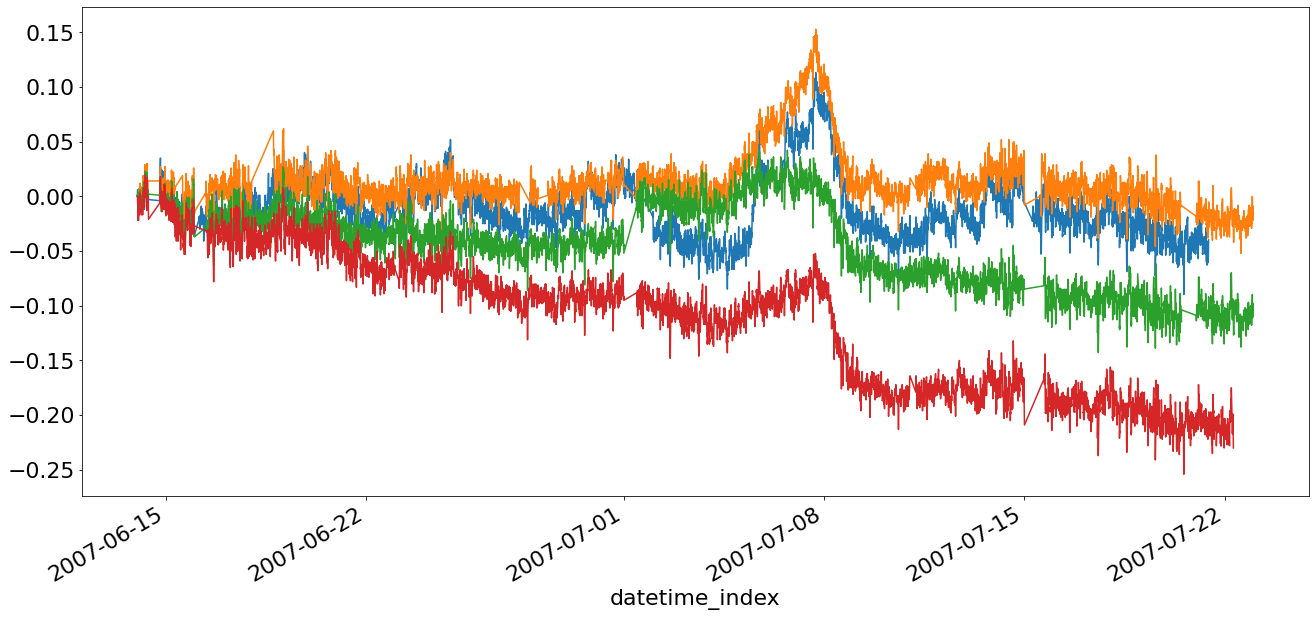

In [17]:
for i in range(0,4):
    gps_df_list[i].gps_relZDispFromDOY165_m.plot()

# to do:: LIST-ISIZE THIS!

## rolling average for disp -- reduce noise prior to velocity calculation



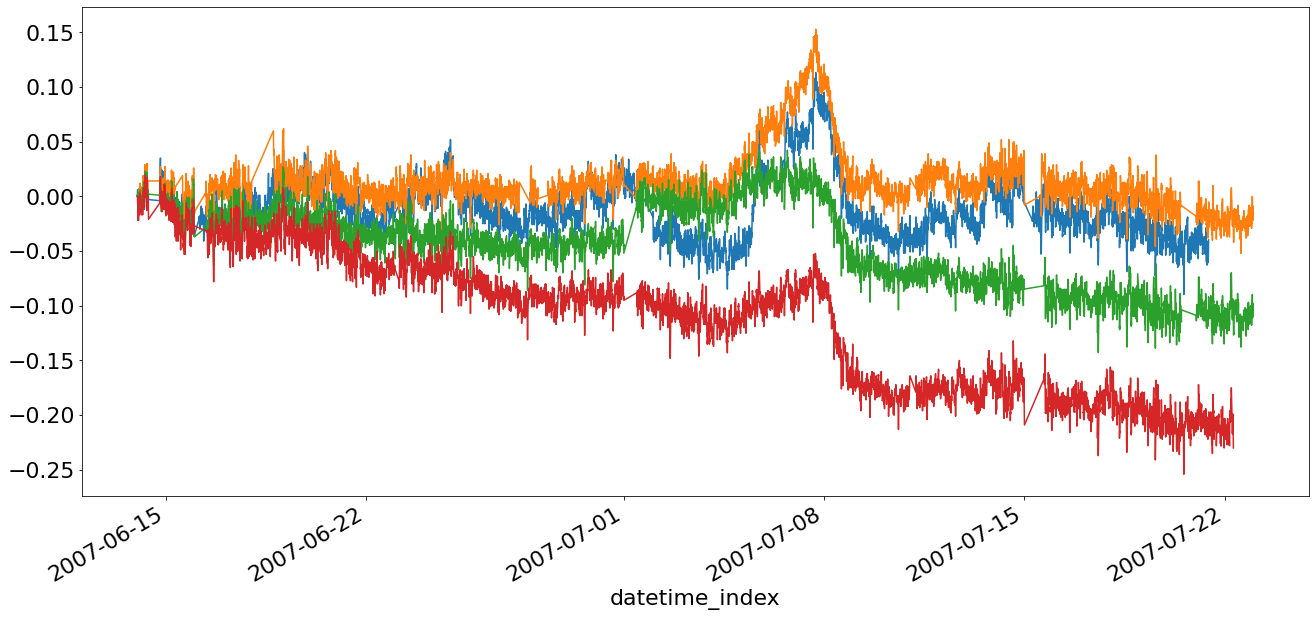

In [18]:
for i in range(0,4):
    gps_df_list[i].gps_relZDispFromDOY165_m.plot()

In [31]:
df_roll_list = []
for i in range(0,4):
    df_roll = gps_df_list[i]

    win_size = '12H' ## rolling average window size
    half_win_size = '6H' ##for left offset to get center labels
    
    
    
    gps_roll = df_roll.gps_relDispFromDOY165_m.resample(win_size,loffset=half_win_size).mean()
    z_roll = df_roll.gps_relZDispFromDOY165_m.resample(win_size,loffset=half_win_size).mean()
    
    vel = np.diff(gps_roll)
#     vel_fill = np.insert(vel,len(vel),np.nan) #backfill
    vel_fill = np.insert(vel,0,np.nan) #forward fill

    print(len(df_roll))
    df_roll = pd.DataFrame({'date_index':gps_roll.index,
                           'gps_roll':gps_roll,
                           'z_roll':z_roll,                            
                           'vel_fill':vel_fill})

    df_roll = df_roll.set_index('date_index')
    
    df_roll_list.append(df_roll)


25383
24959
26282
25886


/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  # Remove the CWD from sys.path while we load stuff.
/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  # This is added back by InteractiveShellApp.init_path()


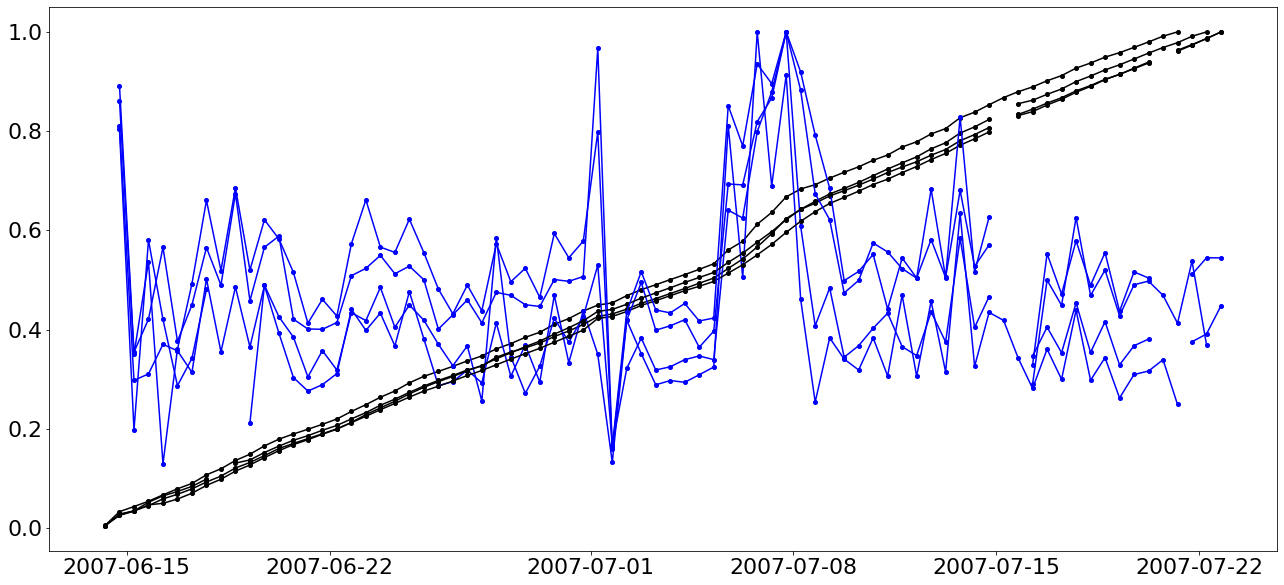

In [32]:
for i in range(0,4):
    df_roll = df_roll_list[i]
    plt.plot(df_roll.gps_roll/np.nanmax(df_roll.gps_roll),ls='-',marker='o',ms=4,c='k')
    plt.plot(df_roll.vel_fill/np.nanmax(df_roll.vel_fill),ls='-',marker='o',ms=4,c='b')

In [33]:
df_roll.columns

Index(['gps_roll', 'z_roll', 'vel_fill'], dtype='object')

## something up w z displacement .... ignore for now? 
## Does displacement include Z??

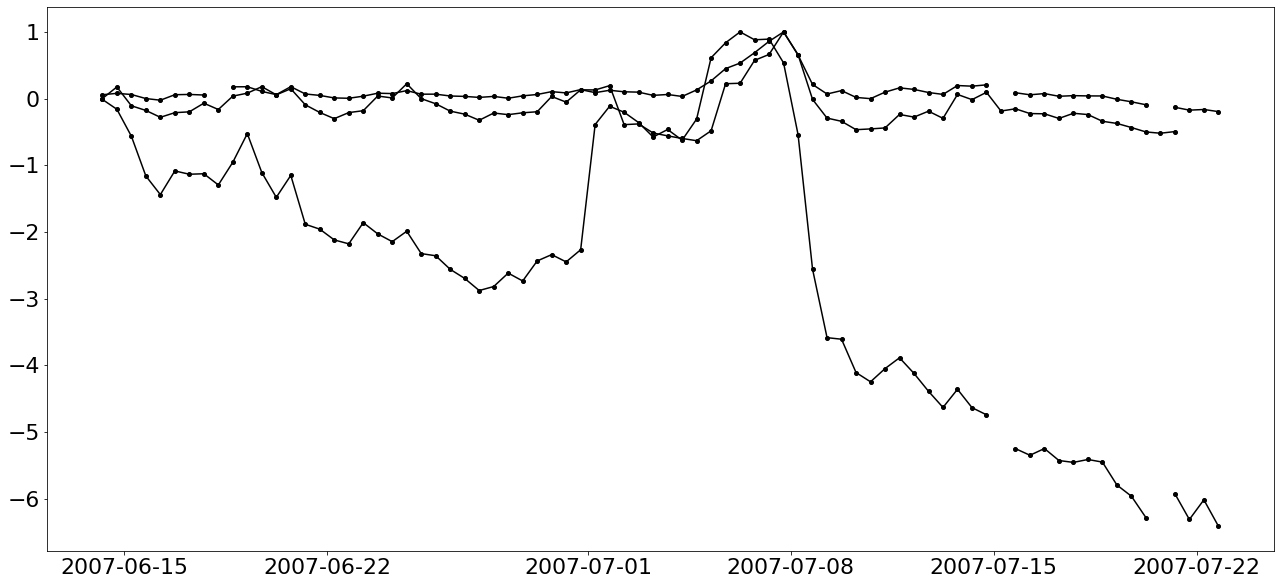

In [34]:
for i in range(0,3):
    df_roll = df_roll_list[i]
    plt.plot(df_roll.z_roll/np.nanmax(df_roll.z_roll),ls='-',marker='o',ms=4,c='k')
#     plt.plot(df_roll.vel_fill/np.nanmax(df_roll.vel_fill),ls='-',marker='o',ms=4,c='b')

In [35]:
pwd


'/Users/theresasawi/Documents/11_Manuscripts/Sawietal_2021/SawiEtAl_2021/src/data'

## Takeaway: velocity jump matches GPS jump

## save ROLLING avg GPS CSVs

In [36]:
for i in range(0,4):
    df_roll = df_roll_list[i]
    df_roll.to_csv(pathOut + f'gps_roll{station[i][-2:]}.csv')

==================================
# Weather Station and Lake Level Data
==================================

## Lake Level

In [37]:
#%% format data

lake_data = [[row.flat[0] for row in line] for line in mat['LakeLevel'][0][0]]


lake_m = list(lake_data[0])
lake_doy = list(lake_data[4])



## Temperature and Precipiatation

In [38]:

#%%temp
  

temp_doy = mat['Meteor'][0][2][1][:,0]

temp_data = mat['Meteor'][0][2][2][:,0]


rain_data = mat['Meteor'][0][2][3][:,0]






# Combine into DF for each 

In [39]:
lake_datetime = pd.to_datetime('2006-12-31',  format='%Y-%m-%d') + pd.to_timedelta(lake_doy, unit='D')
lake_datetime2 = pd.to_datetime('2006-12-31',  format='%Y-%m-%d') + pd.to_timedelta(lake_doy, unit='D')

temp_datetime = pd.to_datetime('2006-12-31') + pd.to_timedelta(temp_doy, unit='D')
temp_datetime2 = pd.to_datetime('2006-12-31') + pd.to_timedelta(temp_doy, unit='D')


In [40]:
lake_df = pd.DataFrame({'lake':lake_m,
                         'doy':lake_doy,
                       'datetime':lake_datetime2},
                       index=lake_datetime)


meteor_df = pd.DataFrame({'temp':temp_data,
                         'rain':rain_data,
                         'doy':temp_doy,
                       'datetime':temp_datetime2},
                         index=temp_datetime)

    

## Trim to study bounds

In [41]:
lake_df_0 = lake_df.where(lake_df.doy>=doy1)
lake_df_00 = lake_df_0.where(lake_df_0.doy<doy2).dropna()

meteor_df_0 = meteor_df.where(meteor_df.doy>=doy1)
meteor_df_00 = meteor_df_0.where(meteor_df_0.doy<doy2).dropna()

## plot temp lake rain

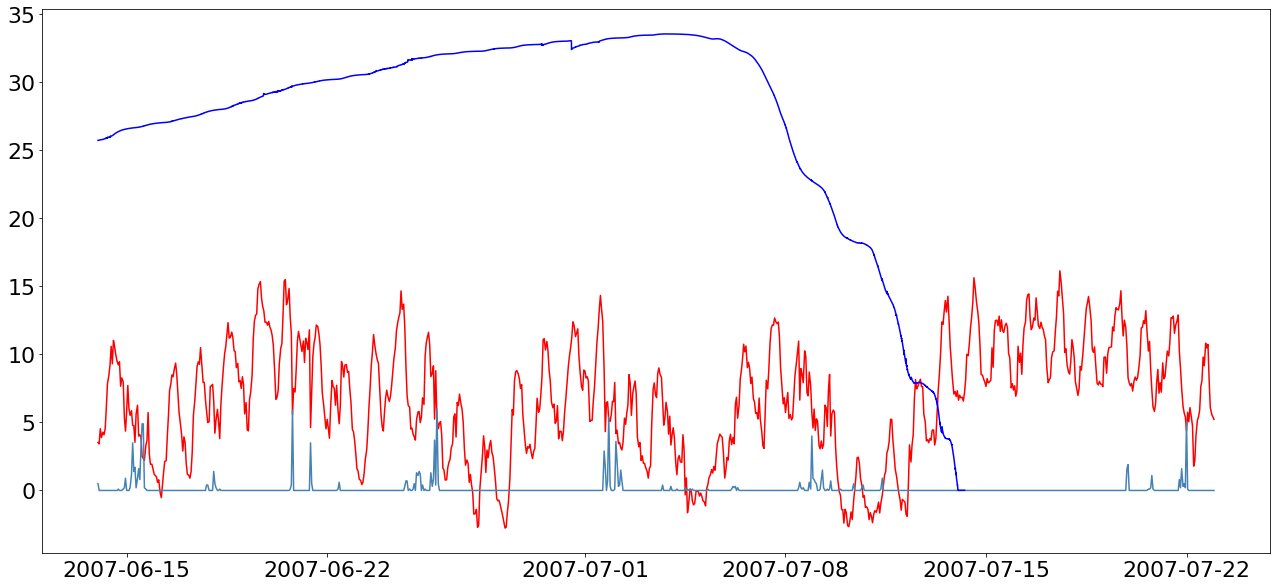

In [42]:
plt.plot(meteor_df_00.datetime,meteor_df_00.temp,'r')
plt.plot(meteor_df_00.datetime,meteor_df_00.rain,'steelblue')

plt.plot(lake_df_00.datetime,lake_df_00.lake,'b')

## save csv for lake, temp and rain -- no rolling needed, this resolution fine



In [43]:
meteor_df_00.to_csv(pathOut + f'meteor_df.csv')
lake_df_00.to_csv(pathOut + f'lake_df.csv')
